# Task-Space Control of a 6 dof manipulator

## Imort all the modules needed for the simulation

In [1]:
from pickle import GLOBAL
import pinocchio as pin
import numpy as np
import sys
import os
from os.path import dirname, join, abspath
from pinocchio.visualize import MeshcatVisualizer
import time
import math
import meshcat
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve
from scipy.spatial.transform import Rotation
import meshcat.transformations as tf
import meshcat.geometry as g
from meshcat.animation import Animation
from numpy.linalg import inv,pinv,eig,norm,svd,det
from random import randint
from matplotlib.animation import FuncAnimation
plt.rcParams['text.usetex'] = True
%matplotlib notebook

## Meshcat functions

In [2]:
def meshcat_material(r, g, b, a):
    import meshcat

    material = meshcat.geometry.MeshPhongMaterial()
    material.color = int(r * 255) * 256 ** 2 + int(g * 255) * 256 + int(b * 255)
    material.opacity = a
    return material


## Bring the URDF model of the robot 

In [3]:
pinocchio_model_dir = '/home/unknown/Documents/Posdoc/ModelsCads/urdf' 
mesh_dir = pinocchio_model_dir + '/kinova_description/meshes/'
urdf_model_path =pinocchio_model_dir + '/j2s6s200_simple.urdf'
model, collision_model, visual_model = pin.buildModelsFromUrdf(urdf_model_path, mesh_dir)
# Choose of the visualizer
viz = MeshcatVisualizer(model, collision_model, visual_model)

## Identify the frame and joint IDs

In [4]:
frameIndex = model.getFrameId('j2s6s200_end_effector')
jointIndex = model.frames[frameIndex].parent

## Initialize the viewer

In [5]:
try:
    viz.initViewer()
except ImportError as err:
    print("Error while initializing the viewer. It seems you should install gepetto-viewer")
    print(err)
    sys.exit(0)

try:
    viz.loadViewerModel("pinocchio")
except AttributeError as err:
    print("Error while loading the viewer model. It seems you should start gepetto-viewer")
    print(err)
    sys.exit(0)
viz.viewer['world'].set_transform(np.array(pin.XYZQUATToSE3([0, 0, 0, 0, 0, 1, 0])))


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


## Manipulator dynamic model

\begin{equation}
\mathbf{
M(q)\ddot{q} + C(q,\dot{q})\dot{q} + g(q) = \tau }
\end{equation}

### The closed loop control law $\tau$ can be written 

\begin{equation}
\mathbf{
{\tau} = M(q)u +  g(q) + C(q,\dot{q})}
\end{equation}
where
\begin{equation}
\mathbf{
u = J^{-1}(q)(\ddot{x}_d+ K_d \dot{\tilde{x}} + K_p {\tilde{x}} - \dot{J}\dot{q})};  ~~~~~~ \tilde{x}= x_d - x
\end{equation} 

## Simulation function

In [6]:
def run_robot():

    def df_dq(model,func,q,h=1e-9):
        dq = pin.utils.zero(model.nv)
        f0 = func(q)
        AM_i = pin.utils.zero([6,3,3])
        for iq in range(model.nv):
            dq[iq] = h
            res2 = (func(pin.integrate(model,q,dq)) - f0)/h
            AM_i[iq,:,:] = np.array([ [res2[0],res2[3],res2[4]], [res2[3],res2[1],res2[5]], [res2[4],res2[5],res2[2]] ])
            dq[iq] = 0
        return AM_i
    
    def calc_jac3(q):
        """ Compute Jacobian """
        pin.forwardKinematics(model,data,q)
        pin.updateFramePlacements(model,data)
        pin.computeJointJacobians(model, data, q)
        J=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED)
        Jbl = J[:3]
        R = Jbl@Jbl.T
        Rv = np.array([R[0][0],R[1][1], R[2][2], R[0][1], R[0][2], R[1][2]])                      
        return Rv.copy()
    
    # Create data required by the algorithms
    data = model.createData()

    # Sample a random configuration
    q =np.array([0, 3.2, 1.5, np.pi, 1.9,0])
    qdot = pin.utils.zero(model.nv) # this is the angular velocity 
    a = pin.utils.zero(model.nv)
    qdot_max = np.array([0.63, 0.63, 0.63, 0.84, 0.84,0.84]) #1,2,3 = 36 deg/s; 4,5,6 =48 deg/s 

    pin.forwardKinematics(model,data,q)
    pin.updateFramePlacements(model,data) #Computes the placement of all the joints
    OM_act=data.oMf[model.getFrameId("j2s6s200_end_effector")]
    #print(OM_act.translation)
    kappa = 1
    d_bar = 0.1
    # Control variables
    nuvs = 5
    kvs = np.array([nuvs, nuvs, nuvs, nuvs, nuvs, nuvs])
    Kv = np.diag(kvs)

    luvs = 5
    kps = np.array([luvs, luvs, luvs,luvs, luvs, luvs])
    Kp = np.diag(kps)

    alpha = 20
    t = 0
    dt = 5e-2
    T = 5
    N = math.floor(T/dt)
    
    # for graphs
    t_list = []
    u_list = []    
    q_list = [] #q
    pose_list = []
    pose_des_list = []
    Mdn_list = []
    Md_list = []
    kappa_list = []
    d_list = []
    Dkappa_list = []
    E1_list = []
    E2_list = []
    posdot_list = []
    xo=-0.2; yo =-0.25; zo=0.4 # Position of the obstacle  -0.38478977, -0.5, 0.4
    # This is the desired orientation and pose. The static pose is [-0.38478977 -0.0098      0.38623122]
    oMdes = pin.SE3(OM_act.rotation,np.array([-0.18478977, -0.5, 0.4]))  # pin.SE3(OM_act.rotation,OM_act.translation) #
    
    viz.viewer['world/ball'].set_object(g.Sphere(0.03),
                                    meshcat_material(*[0.4, 0.5,0.1, 1]))
    viz.viewer['world/ball'].set_transform(tf.translation_matrix([oMdes.translation[0]*-1, 
                                                                  oMdes.translation[1]*-1, oMdes.translation[2]]))
    
    viz.viewer['world/obs'].set_object(g.Sphere(0.03),
                                    meshcat_material(*[1, 0.16, 0.12, 1]))
    viz.viewer['world/obs'].set_transform(tf.translation_matrix([xo*-1, yo*-1, zo]))

    viz.viewer['world/ball0'].set_object(g.Sphere(0.03),
                                    meshcat_material(*[0.1, 0.5, 1, 1]))
    viz.viewer['world/ball0'].set_transform(tf.translation_matrix([OM_act.translation[0]*-1, 
                                                                  OM_act.translation[1]*-1, OM_act.translation[2]]))
           
    for k in range(N):
        t += dt
        tic = time.time()

        pin.forwardKinematics(model,data,q)
        pin.updateFramePlacements(model,data)
        OM_act = data.oMf[frameIndex]

        oriErrorRotm = OM_act.rotation.T@oMdes.rotation
        rot = Rotation.from_matrix(oriErrorRotm)
        oriErrorEul = rot.as_euler('YXZ')
        posError = OM_act.translation.T-oMdes.translation.T
        posError = np.concatenate((posError,oriErrorEul))


        pin.computeJointJacobians(model, data, q) # Compute all the Jacobians for all the joints
        J=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED) # in the base frame  
        dJ = pin.computeJointJacobiansTimeVariation(model,data,q,qdot) # Derivative of the Jacobian
        Jbl = J[:3] # linear part of the Jacobian
        Al = Jbl@Jbl.T 
        Al_inv = inv(Al)      
        Al_det = det(Al)        
        pos = np.array([OM_act.translation[0],OM_act.translation[1],OM_act.translation[2]])
        dJ_dqn = df_dq(model,lambda _q: calc_jac3(_q),q)
        
        for i in range(6):
            dJ_dqn[i,:,:] = dJ_dqn[i]*qdot_max[i]
        P_o = np.array([xo,yo,zo])
        d = P_o.T - pos.T 
        #dir_obs = P_o@ d/norm(d)
        #print(dir_obs)
        Zeta = norm(sum(dJ_dqn)@Al_inv)*abs(kappa)
        
        if (norm(d) <= d_bar):
            Dkappa =  Zeta*np.tanh(alpha*d.T@(Jbl@qdot))
        else:
            Dkappa = 0

        if (norm(d) <= d_bar):  
            kappa = kappa + Dkappa*dt
        else:
            kappa = 1   
        Md = kappa*Al_inv
        
        if Al_det < 1e-15:  
            Al_det = 0.0                
        if Al_det == 0.0:
            E_1 = math.nan
            E_2 = math.nan
        else:
            E_1 = Zeta
            E_2 = Dkappa

        xdot = J@qdot
        # Compute torque control
        u = -Kp@posError - Kv@xdot + dJ@qdot
        a = solve(J,u)
        tau = pin.rnea(model, data, q, qdot, a)

        # Compute forward dynamics
        qddot = pin.aba(model, data, q, qdot, tau)

        qdot = qdot + qddot * dt 
        q = pin.integrate(model,q,qdot*dt)

        # Show model with a visualizer of your choice
        viz.display(q)
        q_list.append(q)
        pose_list.append(pos)
        pose_des_list.append(oMdes.translation)
        t_list.append(t)
        u_list.append(tau)
        d_list.append(norm(d))
        Mdn_list.append(norm(Md))
        Md_list.append((Md))
        kappa_list.append(kappa)
        Dkappa_list.append(Dkappa)
        E1_list.append(E_1)
        E2_list.append(E_2)
        posdot_list.append(xdot)
        toc = time.time() 
        ellapsed = toc - tic
        dt_sleep = max(0,dt - (ellapsed))
        time.sleep(dt_sleep)

    t_list = np.array(t_list)
    u_list = np.array(u_list)
    q_list = np.array(q_list)
    pose_list = np.array(pose_list)
    pose_des_list = np.array(pose_des_list)
    d_list = np.array(d_list)
    Mdn_list = np.array(Mdn_list)
    Md_list = np.array(Md_list)
    kappa_list = np.array(kappa_list)
    Dkappa_list = np.array(Dkappa_list)
    E1_list = np.array(E1_list)
    E2_list = np.array(E2_list)
    posdot_list = np.array(posdot_list)
    return t_list, u_list, q_list, pose_list, pose_des_list, d_list, Mdn_list, kappa_list, Dkappa_list, E1_list, E2_list, posdot_list, Md_list


In [7]:
isinstance(viz, pin.visualize.MeshcatVisualizer) and viz.viewer.jupyter_cell()

In [8]:
t_list, u_list, q_list, pose_list, pose_des_list, d, Mdn, kappa, Dkappa, E1, E2, posdot, Md = run_robot()

In [27]:
def animate(i):
    """Plot an ellipsoid"""
    radii = 1.0 / np.sqrt(np.diag(Md[i,:,:]))
    U, s, rotation = svd(Md[i,:,:])
    u = np.linspace(0.0, 2.0 * np.pi, 50)
    v = np.linspace(0.0, np.pi, 50)
    print(radii)
#     for i in range(len(radii)):
#         cartesian coordinates that correspond to the spherical angles:
    x = np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    
    x[x>0] *= radii[0] 
    # rotate accordingly
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) 
            
    ax.clear()  # Clears the figure to update the line, point,   
#     # Plot:
    ax.plot_surface(x, y, z,  rstride=5, cstride=5, color='r')

    # plot ellipsoid
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
    ax.set_xlim(-0.4,0.8)
    ax.set_ylim(-0.4,0.8)
    ax.set_zlim(-0.6,0.6)
    #plt.show()

<IPython.core.display.Javascript object>


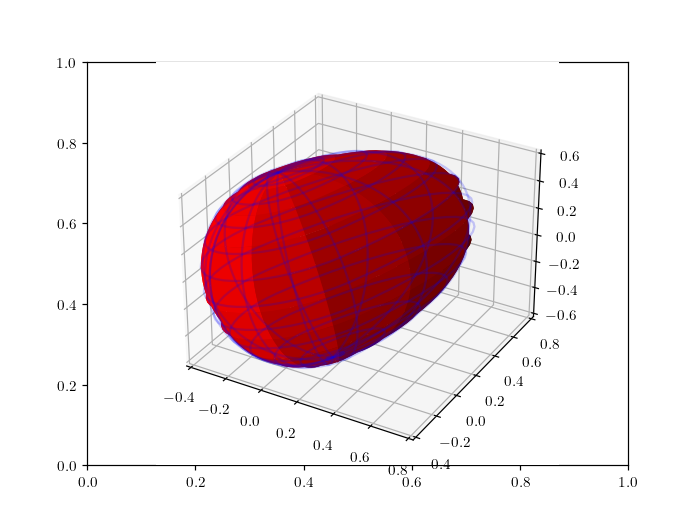

In [31]:
fig, ax = plt.subplots()
ax = fig.add_subplot(111, projection='3d')
anim = FuncAnimation(fig, animate, frames=len(Md), interval=20, repeat=False)
plt.show()

#plt.quiver(pose_list[:,0],pose_list[:,1],posdot[:,0],posdot[:,1])
#plt.show()
#%matplotlib inline
#X, Y = np.meshgrid(pose_list[::1,0], pose_list[::1,1])
#Xdot, Ydot = np.meshgrid(posdot[::1,0], posdot[::1,1])
#plt.quiver(X,Y,Xdot,Ydot)
#plt.show()
#plt.ion()
#plt.figure()
#plt.contour(X,Y,Z)


/tmp/ipykernel_10478/476603297.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 2, 1)


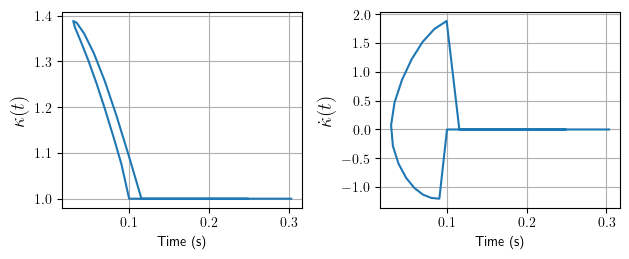

In [9]:
#Graph kappa
fig, ax = plt.subplots()
ax = plt.subplot(2, 2, 1)
plt.plot(d, kappa)
ax.set_ylabel(r"$\kappa(t)$", fontsize = 14)
ax.set_xlabel('Time (s)')
plt.grid(True)
fig.tight_layout()

ax = plt.subplot(2, 2, 2)
plt.plot(d, Dkappa)
ax.set_ylabel(r"$\dot{\kappa}(t)$", fontsize = 14)
ax.set_xlabel('Time (s)')
plt.grid(True)
fig.tight_layout()
plt.show()


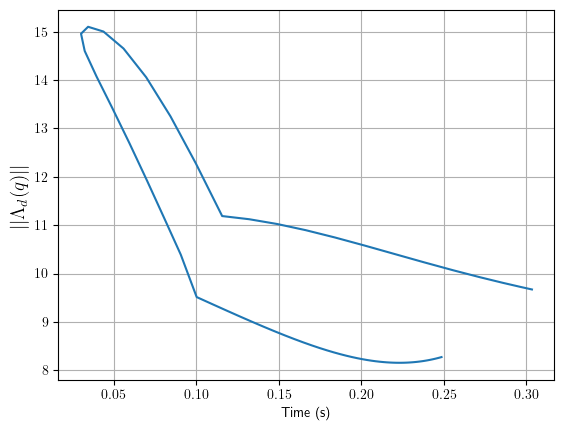

In [10]:
fig, ax = plt.subplots()
#ax = plt.subplot(3, 2, 1)
plt.plot(d, Mdn)
ax.set_ylabel(r"$ || \Lambda_d(q) || $", fontsize = 14)
ax.set_xlabel('Time (s)')

plt.grid(True)
plt.show()

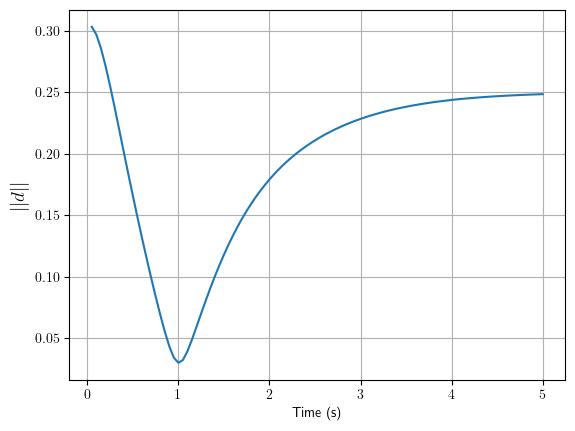

In [27]:
fig, ax = plt.subplots()
#ax = plt.subplot(3, 2, 1)
plt.plot(t_list, d)
ax.set_ylabel(r"$ ||d|| $", fontsize = 14)
ax.set_xlabel('Time (s)')
plt.grid(True)
plt.show()

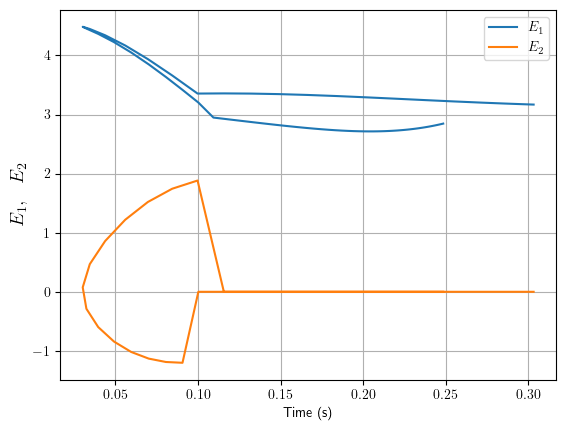

In [11]:
fig, ax = plt.subplots()
#ax = plt.subplot(3, 2, 1)
plt.plot(d, E1)
plt.plot(d, E2)
ax.legend((r"$E_1$",r"$E_2$"),loc="upper right")
ax.set_ylabel(r"$ E_1,~~ E_2$", fontsize = 14)
ax.set_xlabel('Time (s)')

plt.grid(True)
plt.show()

## Graphs functions ($\tau$, $q$, ($\xi_{ee},\eta_{ee})$)

In [ ]:

def graphs_qs(t_list, q_list):
    fig, ax = plt.subplots()
    plt.plot(t_list, q_list[:, :])
    plt.grid(True)
    ax.set_ylabel(r"$q \ [rad]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$q_0$",r"$q_1$",r"$q_2$",r"$q_3$",r"$q_4$",r"$q_5$"),loc="upper right")
    fig.tight_layout()
    plt.show()

def graphs_taus(t, tau):
    fig, ax = plt.subplots()
    ax = plt.subplot(3, 2, 1)
    plt.plot(t, tau[:, 0])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_0 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 2)
    plt.plot(t, tau[:, 1])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_1 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 3)
    plt.plot(t, tau[:, 2])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_2 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 4)
    plt.plot(t, tau[:, 3])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_3 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 5)
    plt.plot(t, tau[:, 4])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_4 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 6)
    plt.plot(t, tau[:, 5])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_5 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    plt.show()

def graphs_pose(t, pose, pose_des):
    fig, ax = plt.subplots()
    ax = plt.subplot(3, 1, 1)
    plt.plot(t, pose[:, 0])
    plt.plot(t, pose_des[:, 0],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$x \ [m]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    # ax.set_ylim(-0.95, 0.95)
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$x$",r"$x_{d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 1, 2)
    plt.plot(t, pose[:, 1])
    plt.plot(t, pose_des[:, 1],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$y \ [m]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    # ax.set_ylim(-0.95, 0.95)
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$y$",r"$y_{d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 1, 3)
    plt.plot(t, pose[:, 2])
    plt.plot(t, pose_des[:, 2],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$z \ [m]$", fontsize = 14)
    # ax.set_ylim(-0.95, 0.95)
    ax.set_xlim(0, max(t))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$z$",r"$z_{d}$"),loc="upper right")
    fig.tight_layout()
    plt.show()

In [ ]:
graphs_qs(t_list, q_list)

In [ ]:
graphs_taus(t_list, u_list)

In [ ]:
graphs_pose(t_list, pose_list, pose_des_list)